# Benchmarking CLgen
-----
Dec 2016.

In [24]:
# preamble
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from labm8 import fs
from labm8 import viz

import clgen
from clgen import corpus

## Experimental methodology

Experimental platforms: cc[123]. NVIDIA GTX 1080.

* Train on GitHub corpus.
* Generate 1000 samples.
* Reject bad samples.

In [25]:
c = corpus.Corpus.from_json({"path": "~/data/github"})
print("CLgen:      ", clgen.version())
print("Corpus size:", c.size)
print("Vocab size: ", c.vocab_size)

corpus from json
corpus db160e3638cf02daa0cde17b260e3337c8f855ed
creating batches


CLgen:       0.2.1
Corpus size: 20271852
Vocab size:  92


## Experimental results

In [27]:
def parse_file(path):
    """ return model size, num layers, and epochs """
    import re
    m = re.search(r"([0-9]+)x([0-9]+)x([0-9]+)", path)
    return m.group(1), m.group(2), m.group(3) 

data_files = ["benchmark/" + x for x in fs.ls("benchmark")
              if x.startswith("benchmark-") and x.endswith(".json")]
data = dict((parse_file(x), clgen.load_json_file(x)) for x in data_files)
print("read {} data files".format(len(data)))

read 1 data files


## Evaluation

Metrics:

$Time\ per.\ epoch = \frac{training\_time}{num\_epochs}$

$Time\ per.\ sample = \frac{sampling\_time}{num\_samples}$

$Efficiency = \frac{num\_good\_chars}{num\_chars}$

$Throughput = \frac{num\_good\_chars}{sample\_time}$

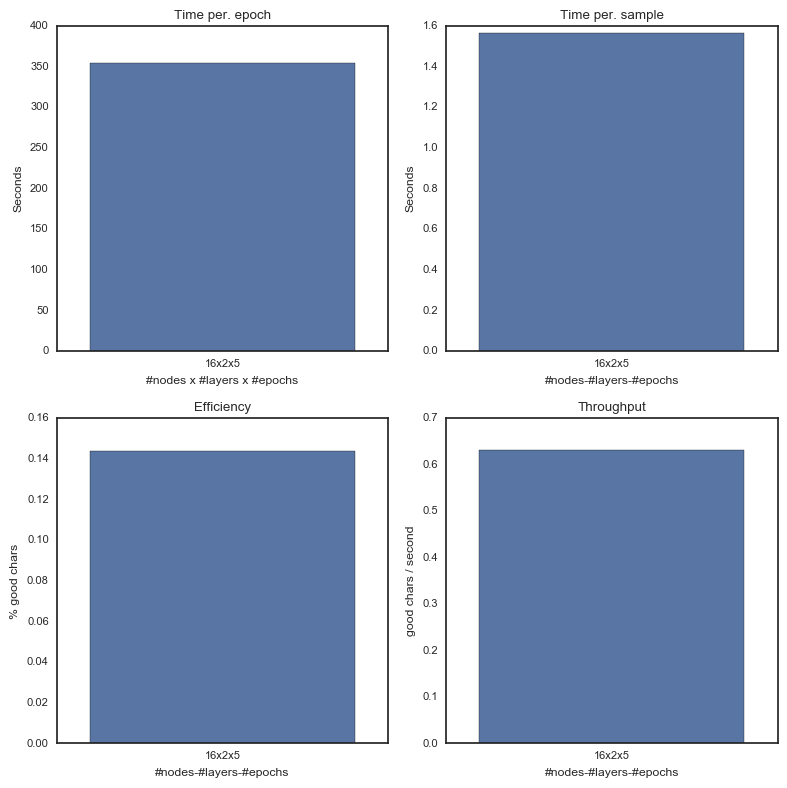

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz
plt.style.use(["seaborn-white", "seaborn-paper"])

def label(path):
    return 'x'.join([str(x) for x in path])

plt.subplots(2, 2)

plt.subplot(2, 2, 1)
x, y = zip(*[(label(x), data[x]["training_time"] / float(x[2]))
             for x in sorted(data.keys())])
sns.barplot(x, y)
plt.title("Time per. epoch")
plt.xlabel("#nodes x #layers x #epochs")
plt.ylabel("Seconds")

plt.subplot(2, 2, 2)
x, y = zip(*[(label(x), data[x]["sampling_time"] / data[x]["num_kernels"])
             for x in sorted(data.keys())])
sns.barplot(x, y)
plt.title("Time per. sample")
plt.xlabel("#nodes-#layers-#epochs")
plt.ylabel("Seconds")
    
plt.subplot(2, 2, 3)
x, y = zip(*[(label(x), data[x]["efficiency"] * 100)
             for x in sorted(data.keys())])
sns.barplot(x, y)
plt.title("Efficiency")
plt.xlabel("#nodes-#layers-#epochs")
plt.ylabel("% good chars")
    
plt.subplot(2, 2, 4)
x, y = zip(*[(label(x), data[x]["throughput"])
             for x in sorted(data.keys())])
sns.barplot(x, y)
plt.title("Throughput")
plt.xlabel("#nodes-#layers-#epochs")
plt.ylabel("good chars / second")

viz.finalise(figsize=(8, 8))